#Determination of Dihedral Angles at Grain Boundary Triple Junctions



###Abstract:
                   
An image processing technique is widely used now a days in the field of materials science. To this end I have used this image processing technique in an polycrystalline microstructure and determined the location of grain boundaries, triple point junction and the dihedral angle at triple point junctions. 


###The steps involved in the image processing:




1.   Converting a microstructure into a binary image. 
2.   Removing of all the internal grain noice (pits and precipitates), by applying morphological operations.
3.  Convert the grain boundaries into a single line pixel (Skeletonize image). 
4.   Locate the triple point junction. 
5.   Get the co-ordinate of grain boundary pixels starting from each triple points. 
     a. Remove all the dangling branch ( if length of the pixel is less then 5).
     b. Get the co-ordinate of true triple point juctiions. 
6. Fit the order 3 polynomial from each triple points in all the three grain boundaries. 
7. Calculate the angle between gain boundaries. 

In [1]:
#import all the necessery packages
import numpy as np
import scipy.ndimage as ndi 
from skimage import color, filters, morphology, measure
import imageio as io
import scipy.misc
import scipy.ndimage
import matplotlib.pyplot as plt
#import cv2 as cv
from scipy import ndimage


In [2]:

!pip install plotnine
!pip install imageio

Here I am using a random polycrystalline image for the purpose of calculating the angle between grain boundary.







/tmp/ipykernel_75318/1079548452.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = io.imread('image.jpeg')


(411, 600) uint8


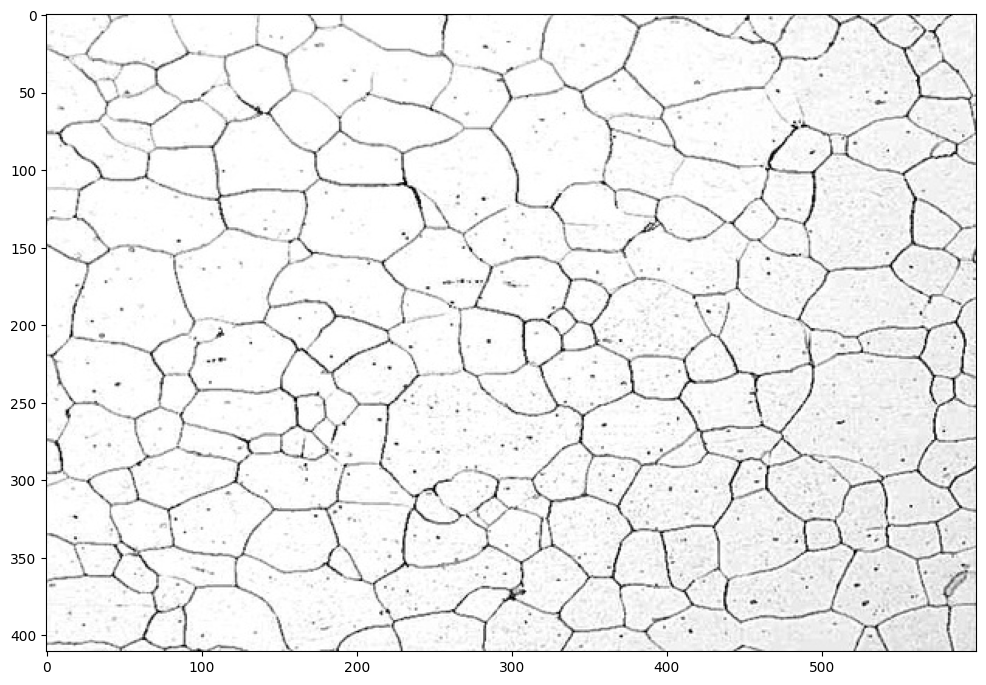

In [3]:


#image
img = io.imread('image.jpeg')
print(img.shape, img.dtype)
img = img.astype(np.uint8)
plt.figure(figsize= (12,12))
plt.imshow(img, cmap='gray')

Now, to remove all the noice form image, I have applied the morphological operations. For applying morphological operations I first converted my image into a binary image. Cummulitive distribution function is used to determining the threshold value for binary image. \\
*Note*: In binary image all the white pixels corresponds to foreground pixel and black piexel corresponds to background pixel . 

In [4]:
def histogram(img, normalized = True):
    freq_hist = ndi.histogram(img, 0, 255, 256)
    bins = np.array([i for i in range (256)])
    cdf = np.cumsum(freq_hist)
    if normalized:
       n = np.sum(freq_hist)
       freq_hist = freq_hist/n
       cdf = cdf/n
       t = filters.threshold_otsu(img)
    plt.bar(bins, freq_hist)
    plt.vlines(t, 0.0, 0.02, colors = 'blue')
    return t

185


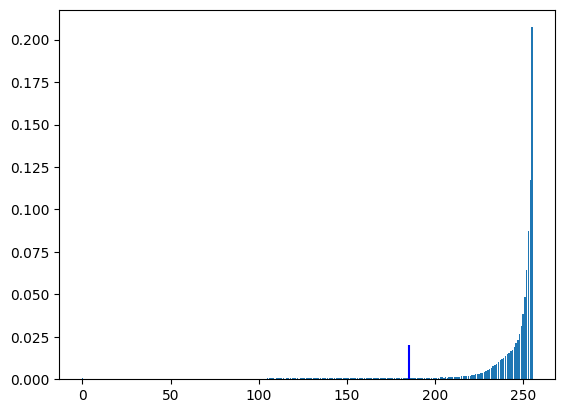

In [5]:
t = histogram(img)
print(t)

[[ True False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


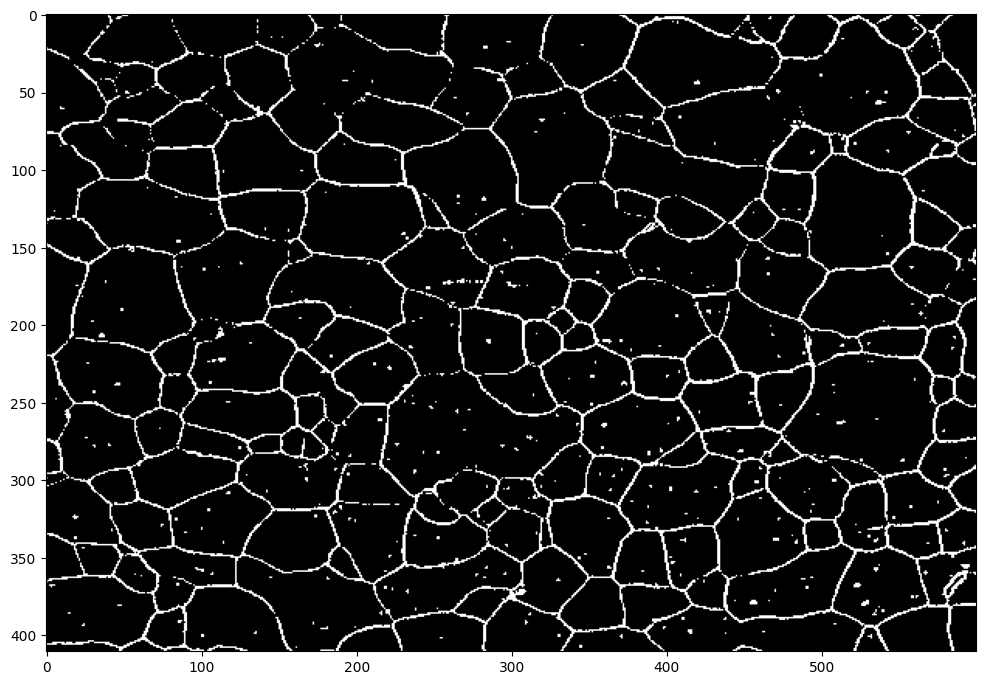

In [8]:
#show binary image
binary = img <= t 
print(binary)
plt.figure(figsize=(12,12))
plt.imshow(binary, cmap='gray')

As the above binary image contain many noice (pits and precipitates), So to reduce this noice and thinned down the foreground pixels ( grain boundary pixels) in to a single pixel, I subsequently apply four different type of morphological operations that are given below;




1.   Dilation ( this operation is use to thick down the foreground pixels).
2.   Erosion ( this operation is use to thin down the foreground pixels). 
3.   Reconstruction.
4.   Thinning ( use to thin down the image into a single fourground pixel).

The below binary image is a result of combination of dilation and erosion operations. Now in this image we can see all the grain boundaries clearly. But the problem is it's still contain noice in it. In order to remove noice from this, a reconstruction operation is performed on the image. 







[[0 1 0]
 [1 1 1]
 [0 1 0]]


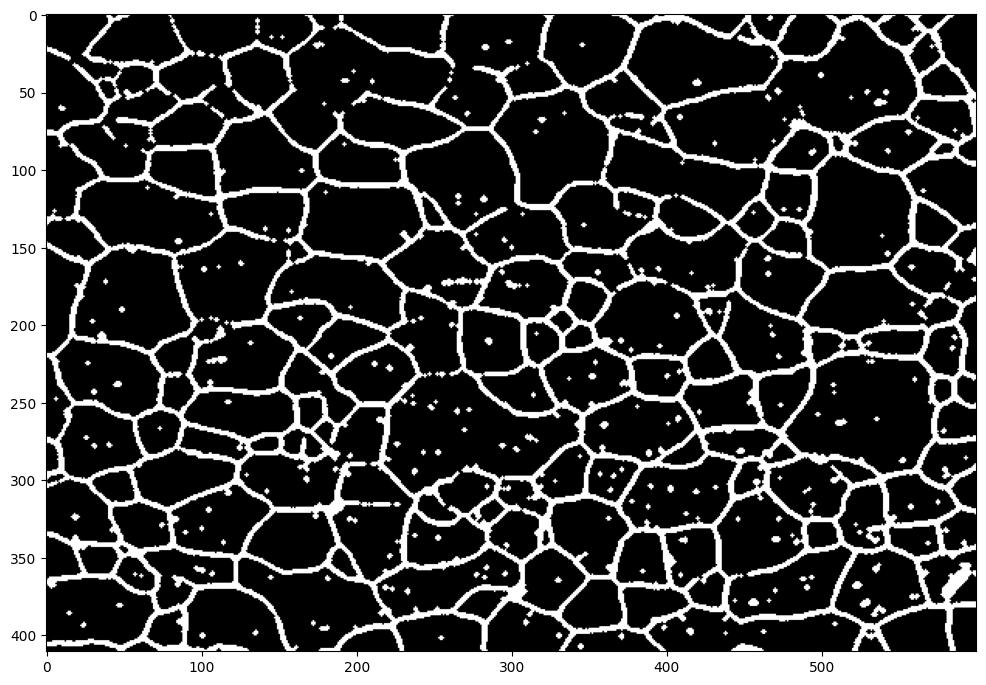

In [10]:
selem = np.array([[0,1,0],[1,1,1],[0,1,0]])
print(selem)
img_1 = morphology.binary_dilation(binary, selem)
img_2 = morphology.binary_dilation(img_1, selem)
img_3 = morphology.binary_erosion(img_2, selem)
img_4 = morphology.binary_dilation(img_3, selem)
img_5 = morphology.binary_erosion(img_4, selem)
plt.figure(figsize=(12,12))

plt.imshow(img_5, cmap='gray')

# Reconstruction
Starting with binary img_5 'A', I created a seed image 'B', mask imae 'M = A' and structuring element 'S'. 

X$_{k}$=$\left( X_{k-1}\oplus S\right) \cap M$

Repaet untill: X$_{k}$= X$_{k-1}$


343


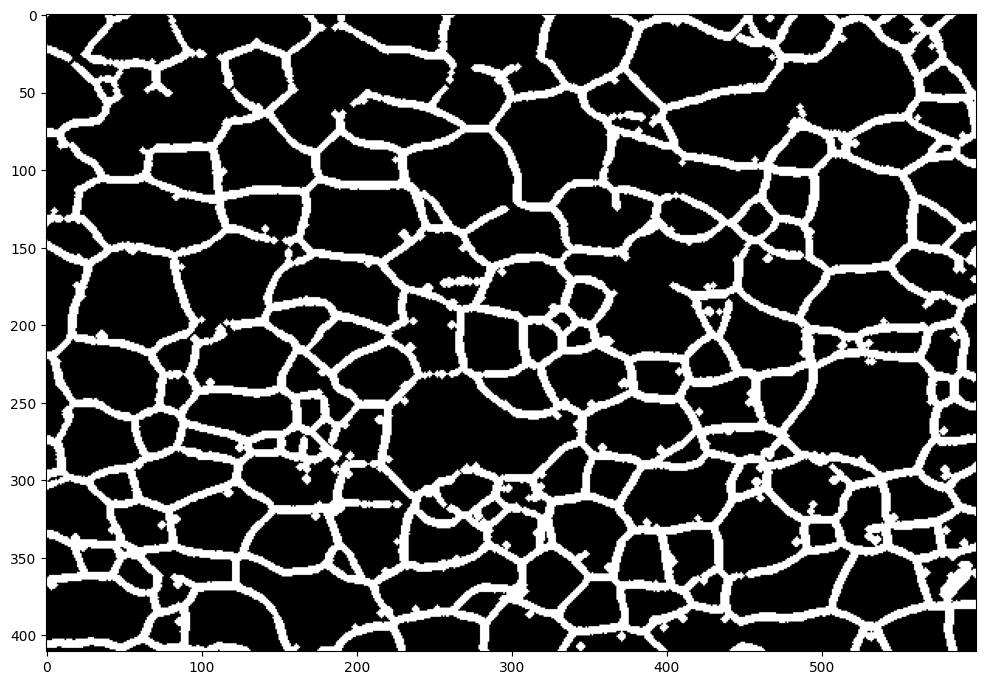

In [11]:
seed = img_4.copy()
seed[1:-1, 1:-1] = img_4.min()
seed_last = np.full((img_4.shape[0], img_4.shape[1]), False)
mask = img_4.copy()
n = 0
while  (not np.array_equal(seed, seed_last) and n <=500):
    n +=1
    seed_last = seed.copy()
    seed = np.logical_and(morphology.dilation(seed_last, selem), mask)
print(n)
plt.figure(figsize=(12,12))

plt.imshow(seed, cmap='gray')

The above seed image does not contain any noice in it. Now I can  perform a thinning operation on this seed image in order to get a single pixel grain bounadaries. 

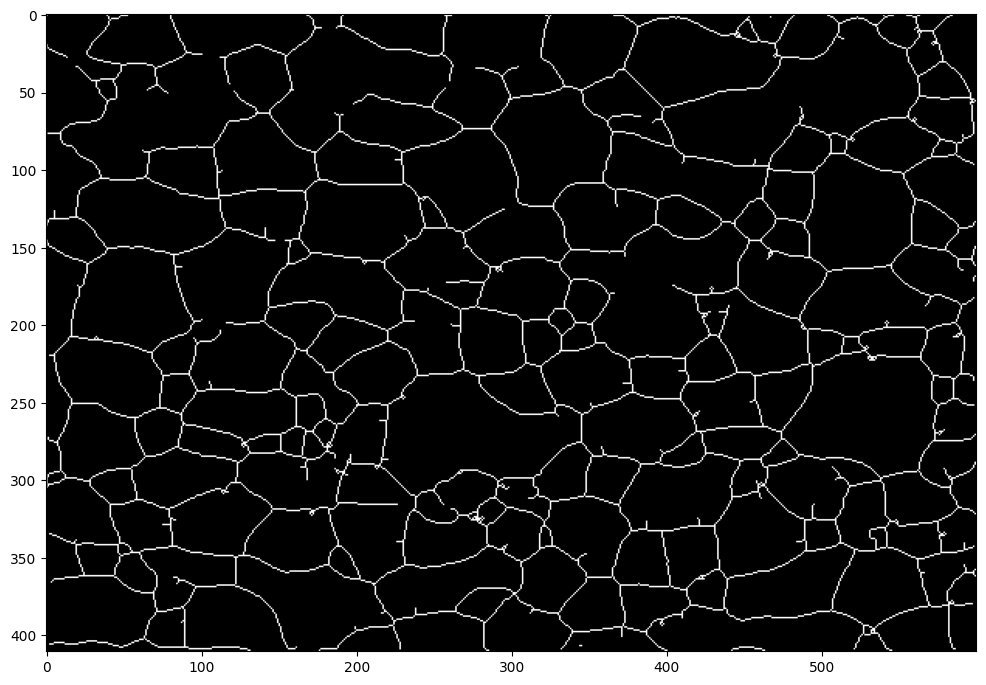

In [12]:
thinned = morphology.skeletonize(seed)
plt.figure(figsize=(12,12))
plt.imshow(thinned, cmap = 'gray')

#Triple Junction location
Now I have a skeletonize image, so the next step is to determine the triple junction location. To do so, I apply a Hit and Miss transformation in single pixel skeletonized image with four different structuring element and all the four structuring elements must be run in all orientations so 16 hit-and-miss passes are required. The four different structuring elements are;

 $\begin{pmatrix}
  0 & 1& 0\\ 
  1 & 1& 0\\
  0 & 1 & 0
\end{pmatrix}$
 $\begin{pmatrix}
  1 & 0& 1\\ 
  0 & 1& 0\\
  0 & 1 & 0
\end{pmatrix}$
 $\begin{pmatrix}
  0 & 0& 1\\ 
  0 & 1& 0\\
  1 & 0 & 1
\end{pmatrix}$
 $\begin{pmatrix}
  0 & 0& 1\\ 
  1 & 1& 0\\
  0 & 1 & 0
\end{pmatrix}$

Once we get the location of triple points in each of the orientation of all the structuring element, we will simply apply 'OR' (logical operation) in all these image together to get the final image that contain all the triple point location.

/tmp/ipykernel_75318/3611231389.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s1_1 = ndimage.binary_hit_or_miss(thinned, structure1=s1).astype(np.int)


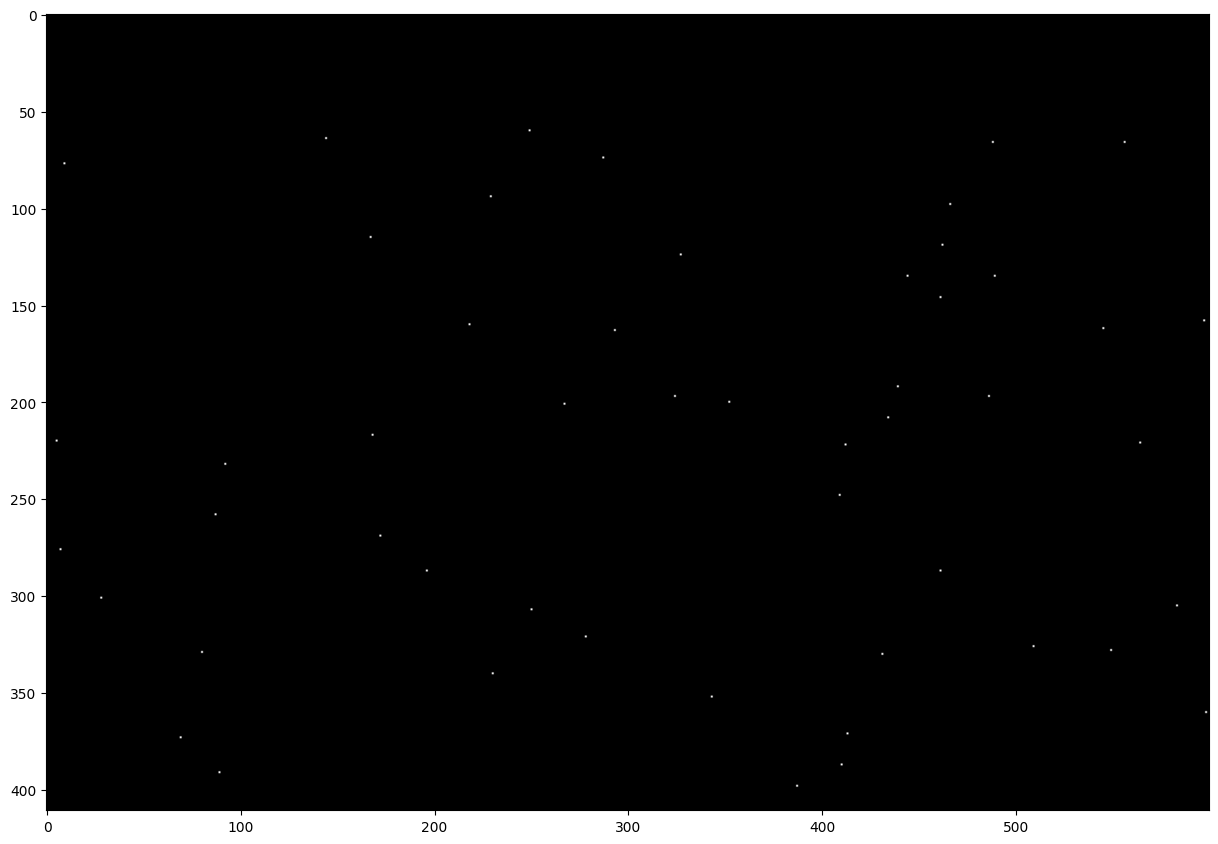

In [14]:

# Construct the structuring element
s1 = np.array((
        [0, 1, 0],
        [1, 1, 0],
        [0, 1, 0]), dtype="int")

 
# Apply hit-or-miss transformation
img_s1_1 = ndimage.binary_hit_or_miss(thinned, structure1=s1).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s1_1, cmap = 'gray')

/tmp/ipykernel_75318/331683721.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s1_2 = ndimage.binary_hit_or_miss(thinned, structure1=s2).astype(np.int)


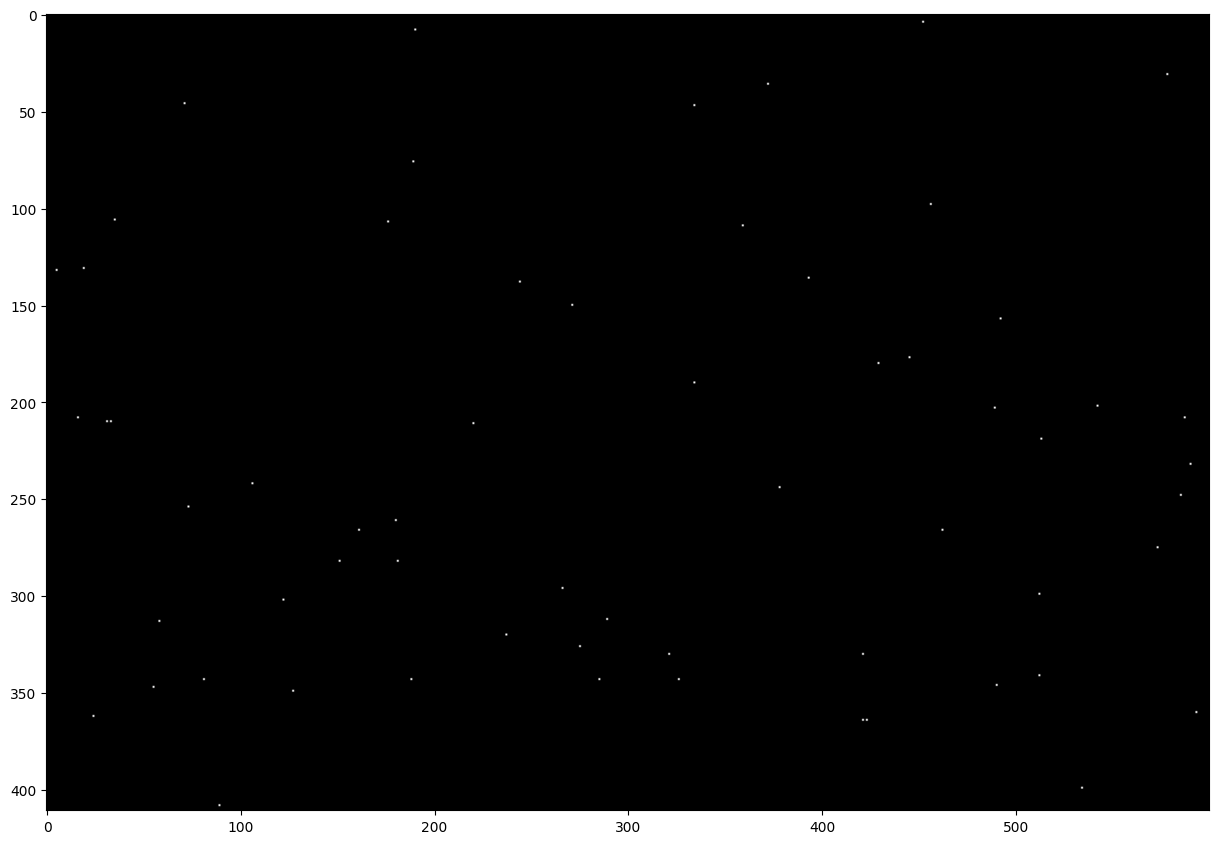

In [15]:
# Construct the structuring element
s2 = np.array((
        [0, 1, 0],
        [1, 1, 1],
        [0, 0, 0]), dtype="int")

 
# Apply hit-or-miss transformation
img_s1_2 = ndimage.binary_hit_or_miss(thinned, structure1=s2).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s1_2, cmap = 'gray')

/tmp/ipykernel_75318/292715583.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s1_3 = ndimage.binary_hit_or_miss(thinned, structure1=s3).astype(np.int)


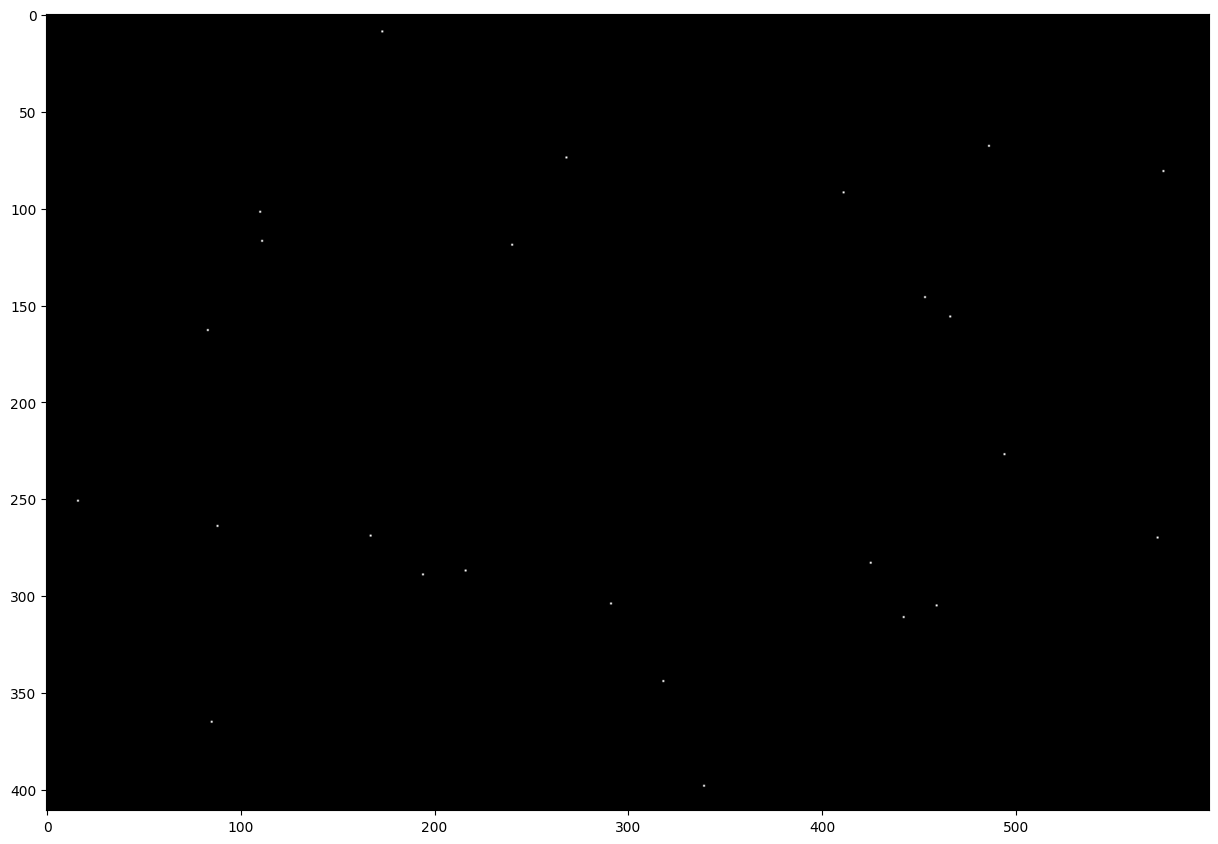

In [16]:
# Construct the structuring element
s3 = np.array((
        [0, 1, 0],
        [0, 1, 1],
        [0, 1, 0]), dtype="int")

 
# Apply hit-or-miss transformation
img_s1_3 = ndimage.binary_hit_or_miss(thinned, structure1=s3).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s1_3, cmap = 'gray')

/tmp/ipykernel_75318/3053005943.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s1_4 = ndimage.binary_hit_or_miss(thinned, structure1=s4).astype(np.int)


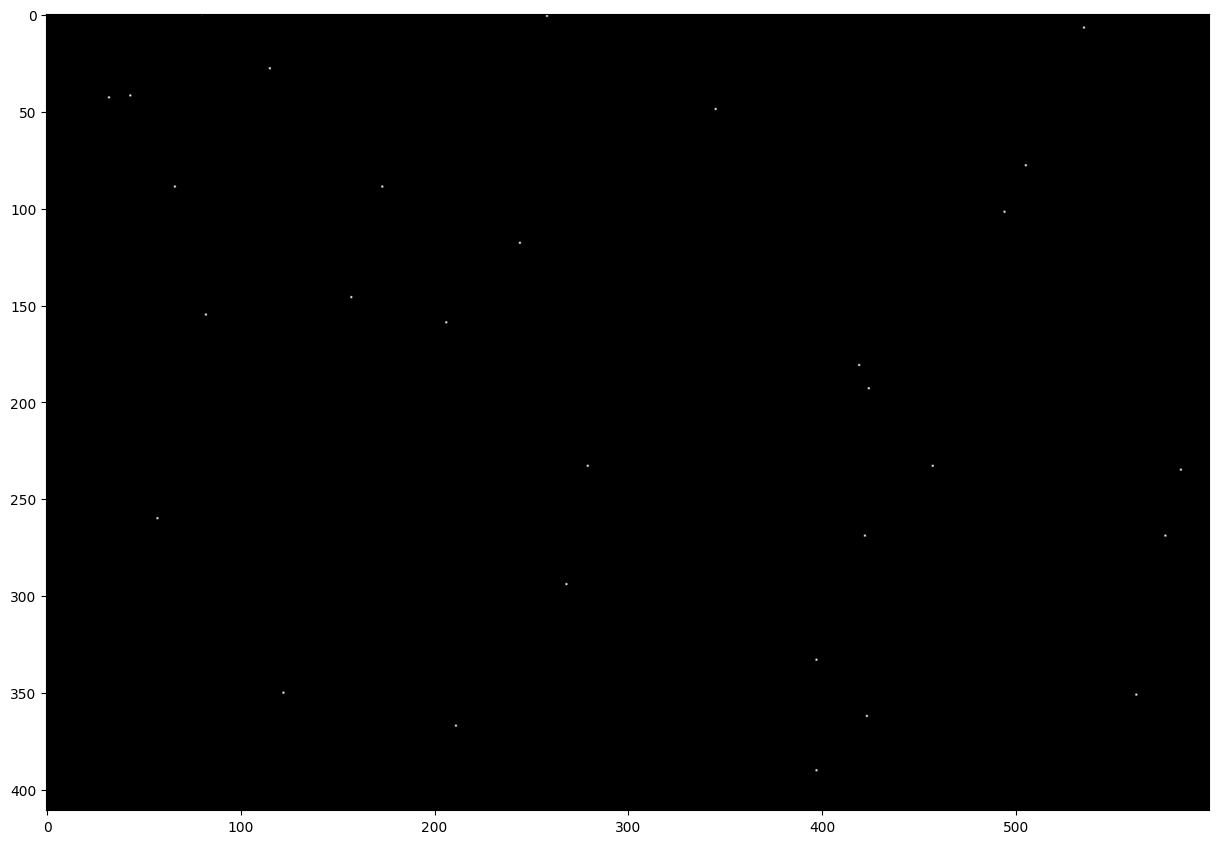

In [18]:
# Construct the structuring element
s4 = np.array((
        [0, 0, 0],
        [1, 1, 1],
        [0, 1, 0]), dtype="int")

 
# Apply hit-or-miss transformation
img_s1_4 = ndimage.binary_hit_or_miss(thinned, structure1=s4).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s1_4, cmap = 'gray')

/tmp/ipykernel_75318/794858624.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s2_1 = ndimage.binary_hit_or_miss(thinned, structure1=s5).astype(np.int)


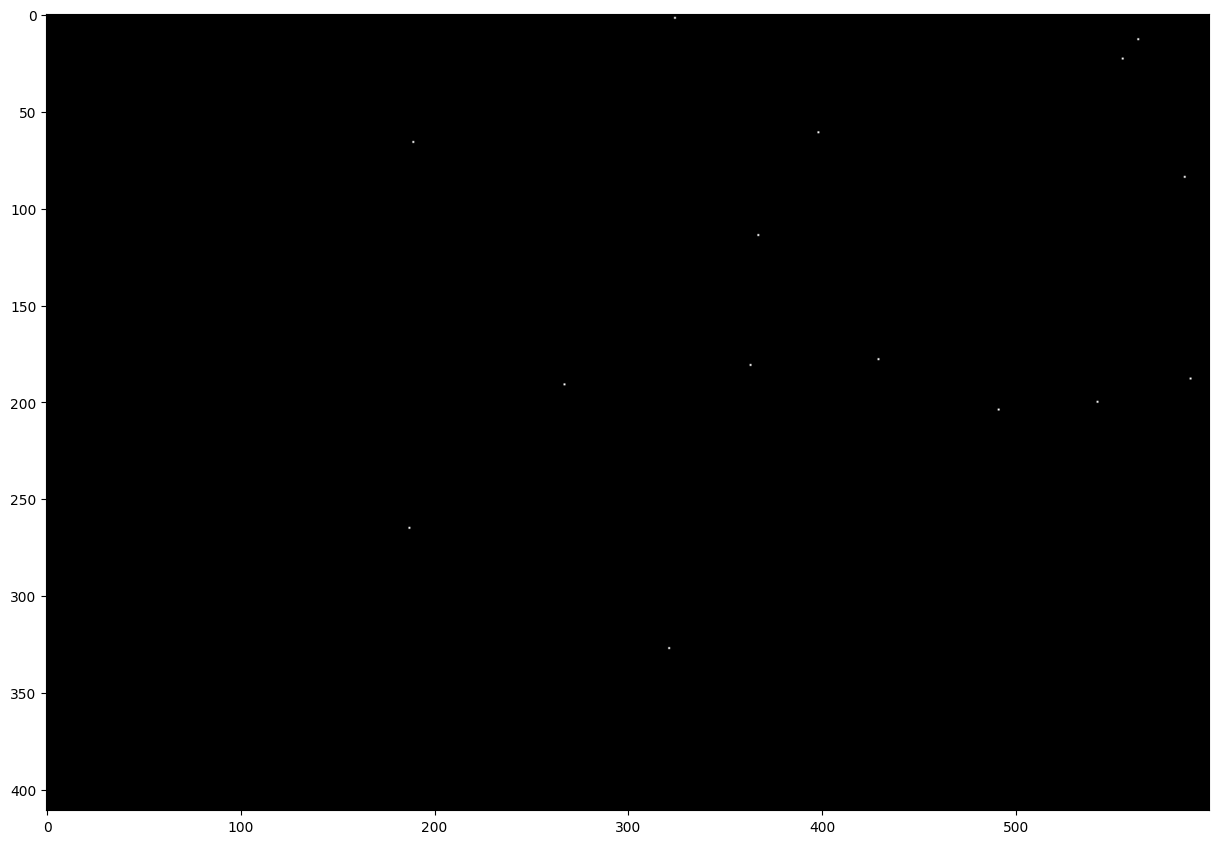

In [19]:
# Construct the structuring element
s5 = np.array((
        [1, 0, 1],
        [0, 1, 0],
        [0, 1, 0]), dtype="int")

 
# Apply hit-or-miss transformation
img_s2_1 = ndimage.binary_hit_or_miss(thinned, structure1=s5).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s2_1, cmap = 'gray')

/tmp/ipykernel_75318/1329503850.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s2_2 = ndimage.binary_hit_or_miss(thinned, structure1=s6).astype(np.int)


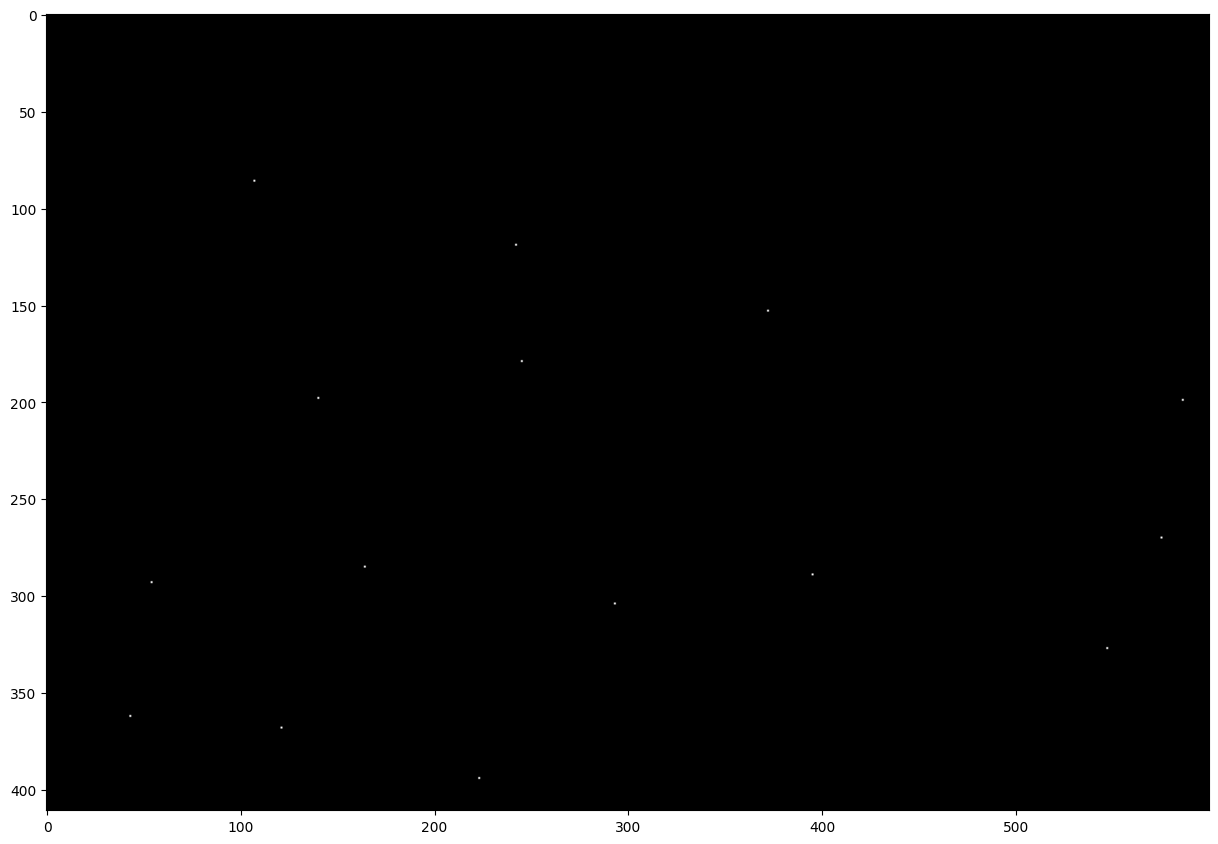

In [20]:
# Construct the structuring element
s6 = np.array((
        [0, 0, 1],
        [1, 1, 0],
        [0, 0, 1]), dtype="int")

 
# Apply hit-or-miss transformation
img_s2_2 = ndimage.binary_hit_or_miss(thinned, structure1=s6).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s2_2, cmap = 'gray')

/tmp/ipykernel_75318/1730468956.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s2_3 = ndimage.binary_hit_or_miss(thinned, structure1=s7).astype(np.int)


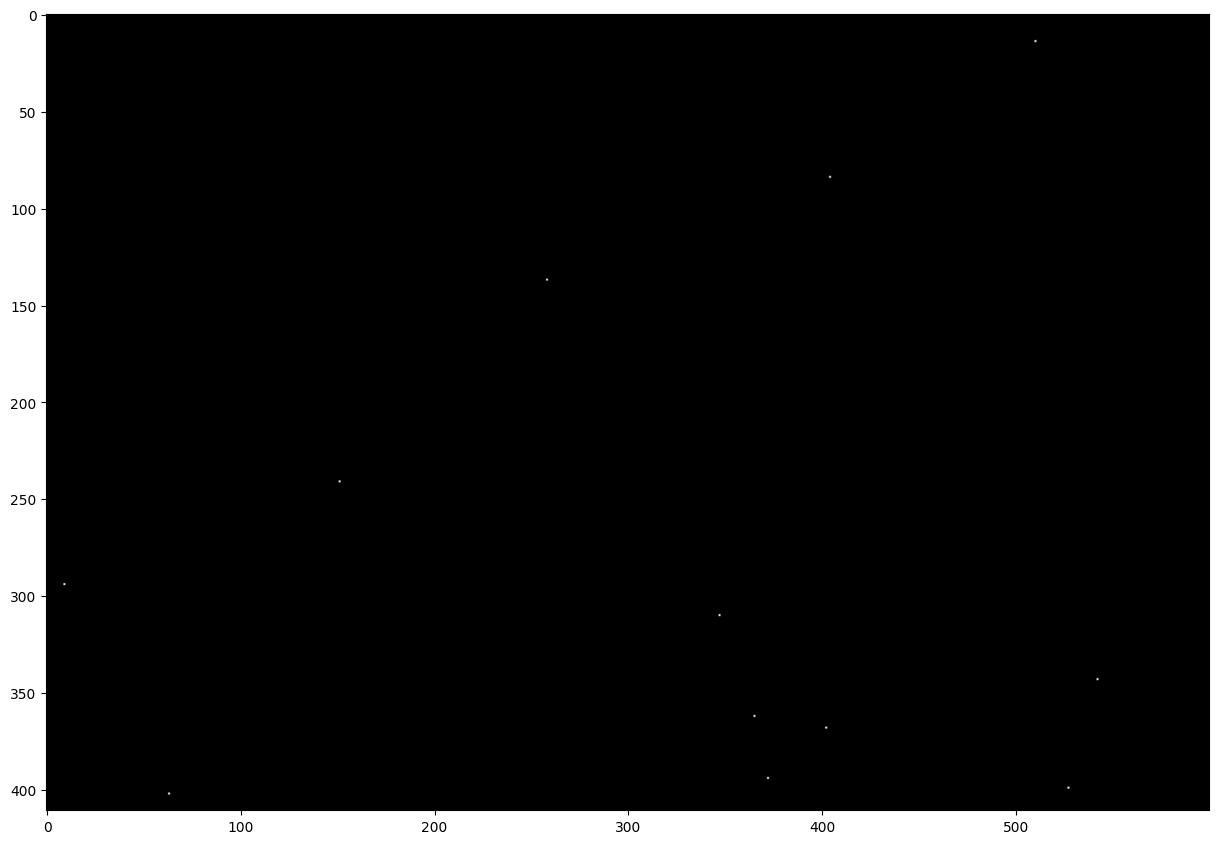

In [21]:
# Construct the structuring element
s7 = np.array((
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 1]), dtype="int")

 
# Apply hit-or-miss transformation
img_s2_3 = ndimage.binary_hit_or_miss(thinned, structure1=s7).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s2_3, cmap = 'gray')

/tmp/ipykernel_75318/1458115396.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s2_4 = ndimage.binary_hit_or_miss(thinned, structure1=s8).astype(np.int)


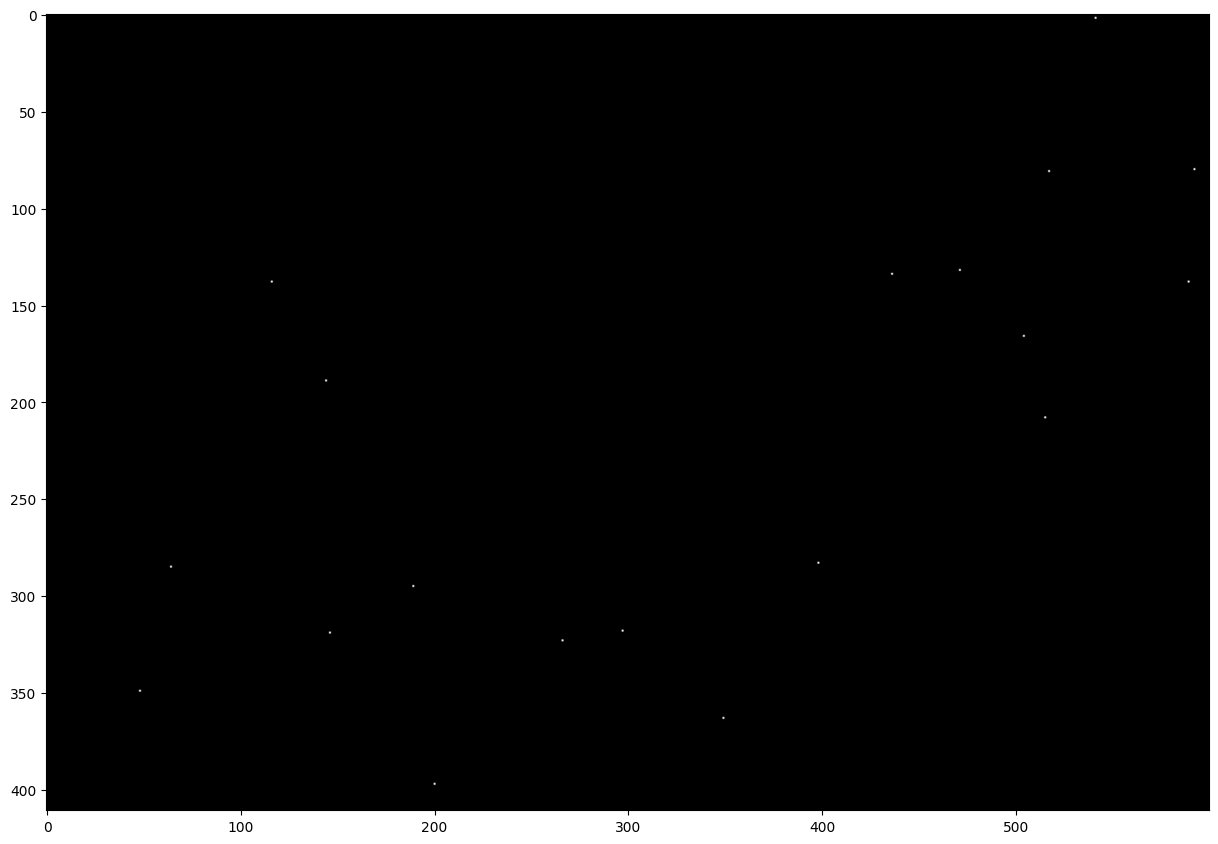

In [22]:
# Construct the structuring element
s8 = np.array((
        [1, 0, 0],
        [0, 1, 1],
        [1, 0, 0]), dtype="int")

 
# Apply hit-or-miss transformation
img_s2_4 = ndimage.binary_hit_or_miss(thinned, structure1=s8).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s2_4, cmap = 'gray')

/tmp/ipykernel_75318/3834873277.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s3_1 = ndimage.binary_hit_or_miss(thinned, structure1=s9).astype(np.int)


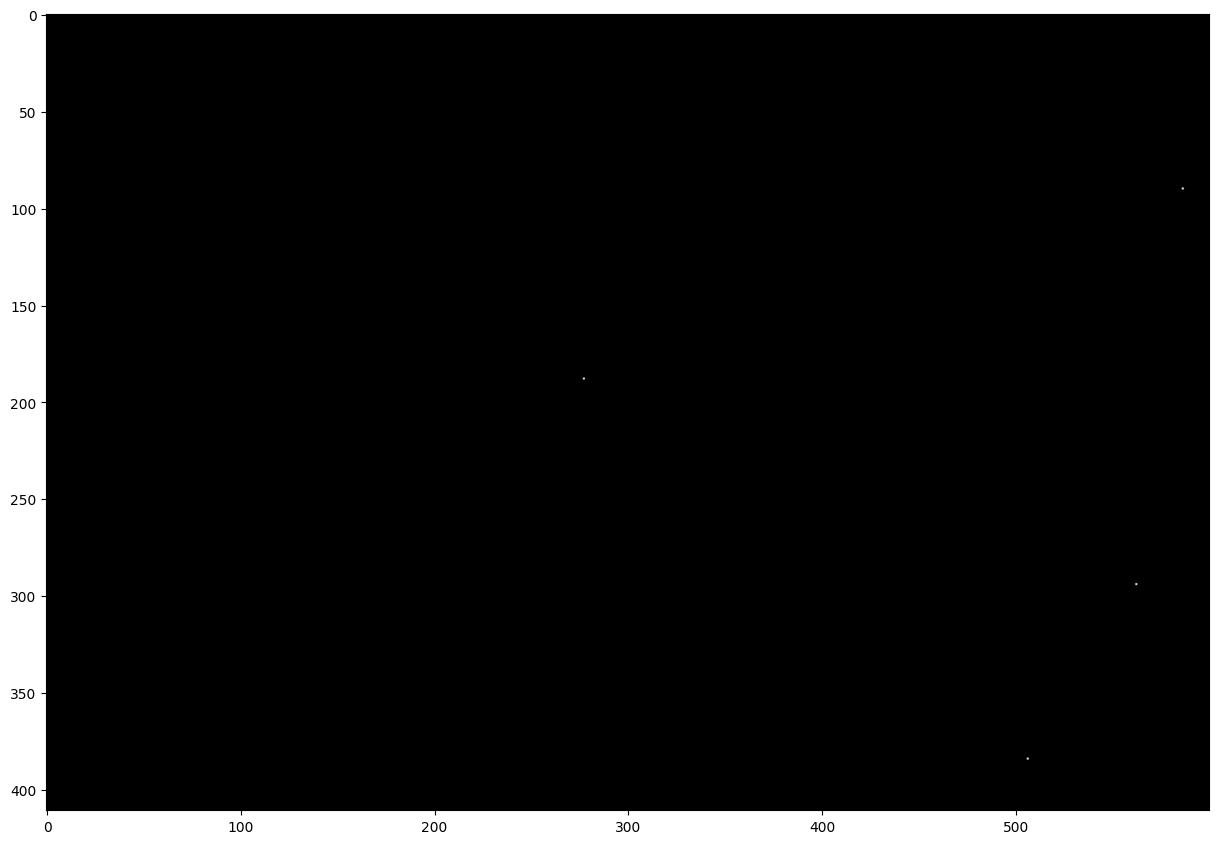

In [23]:
# Construct the structuring element
s9 = np.array((
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 1]), dtype="int")

 
# Apply hit-or-miss transformation
img_s3_1 = ndimage.binary_hit_or_miss(thinned, structure1=s9).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s3_1, cmap = 'gray')

/tmp/ipykernel_75318/292605380.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s3_2 = ndimage.binary_hit_or_miss(thinned, structure1=s10).astype(np.int)


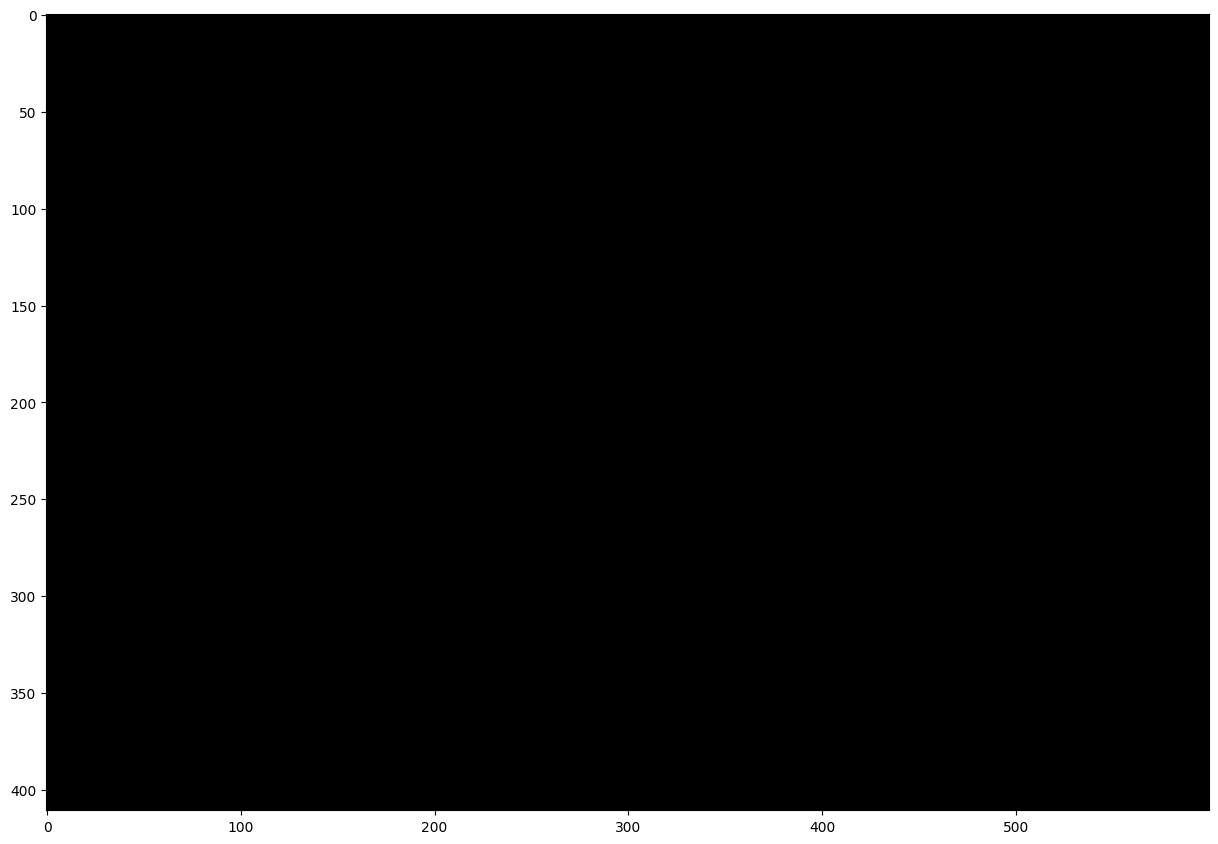

In [24]:
# Construct the structuring element
s10 = np.array((
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 1]), dtype="int")

 
# Apply hit-or-miss transformation
img_s3_2 = ndimage.binary_hit_or_miss(thinned, structure1=s10).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s3_2, cmap = 'gray')

/tmp/ipykernel_75318/1943796126.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s3_3 = ndimage.binary_hit_or_miss(thinned, structure1=s11).astype(np.int)


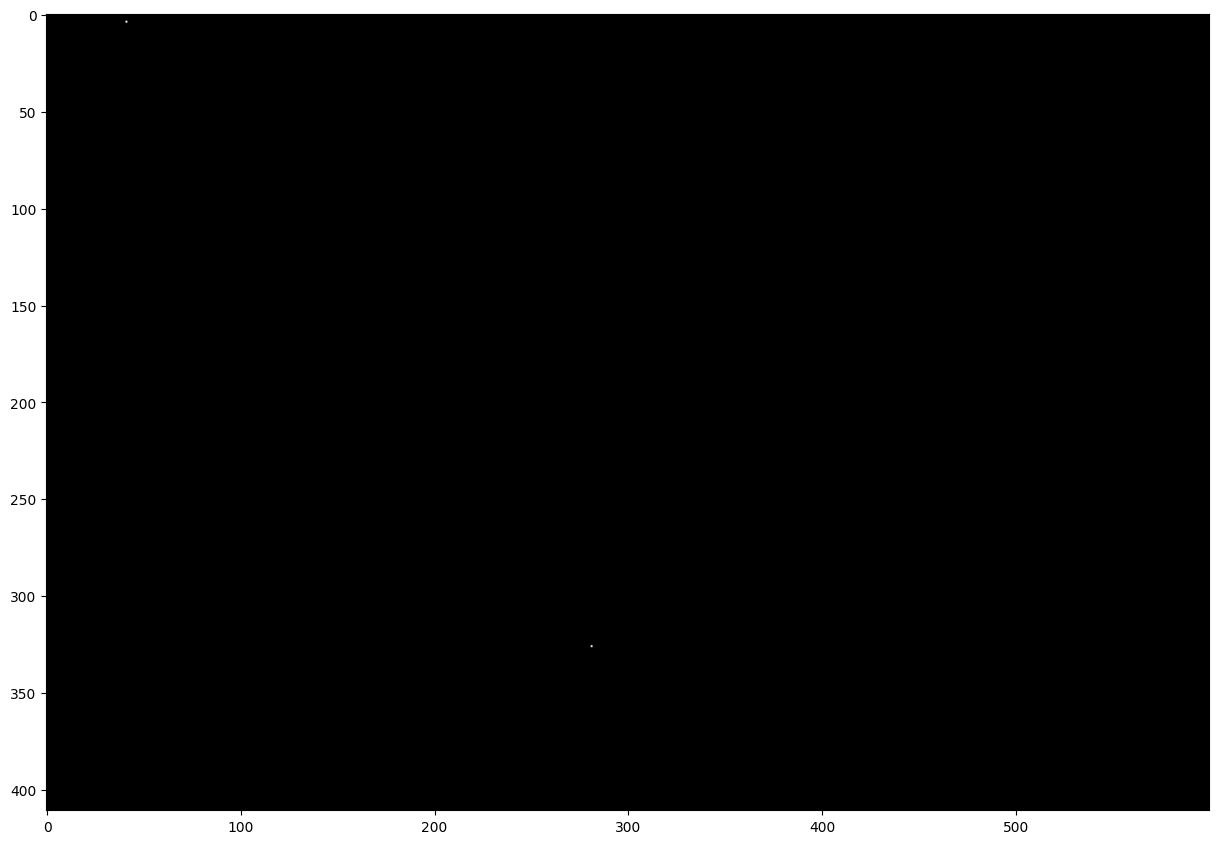

In [25]:
# Construct the structuring element
s11 = np.array((
        [1, 0, 1],
        [0, 1, 0],
        [1, 0, 0]), dtype="int")

 
# Apply hit-or-miss transformation
img_s3_3 = ndimage.binary_hit_or_miss(thinned, structure1=s11).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s3_3, cmap = 'gray')

/tmp/ipykernel_75318/1131376208.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s3_4 = ndimage.binary_hit_or_miss(thinned, structure1=s12).astype(np.int)


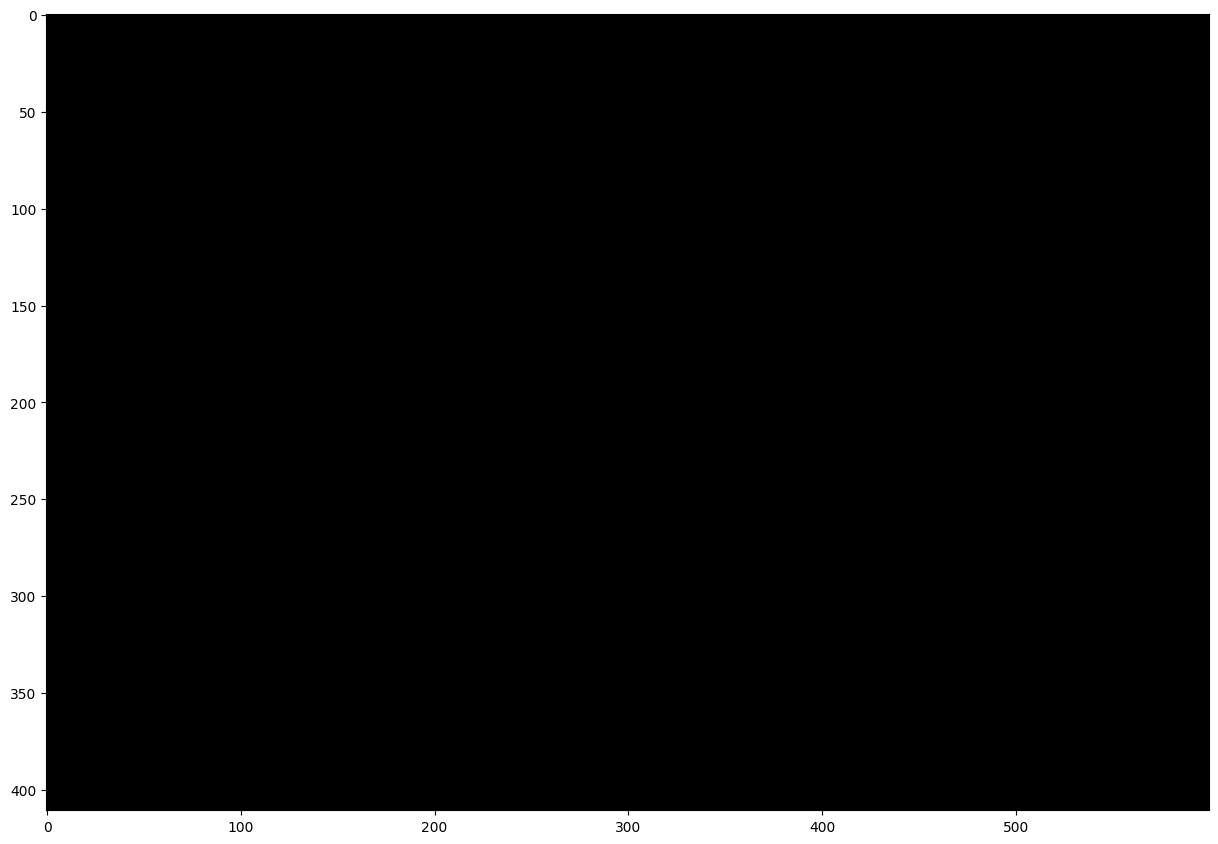

In [27]:
# Construct the structuring element
s12 = np.array((
        [1, 0, 1],
        [0, 1, 0],
        [0, 0, 1]), dtype="int")

 
# Apply hit-or-miss transformation
img_s3_4 = ndimage.binary_hit_or_miss(thinned, structure1=s12).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s3_4, cmap = 'gray')

/tmp/ipykernel_75318/3469067117.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s4_1 = ndimage.binary_hit_or_miss(thinned, structure1=s13).astype(np.int)


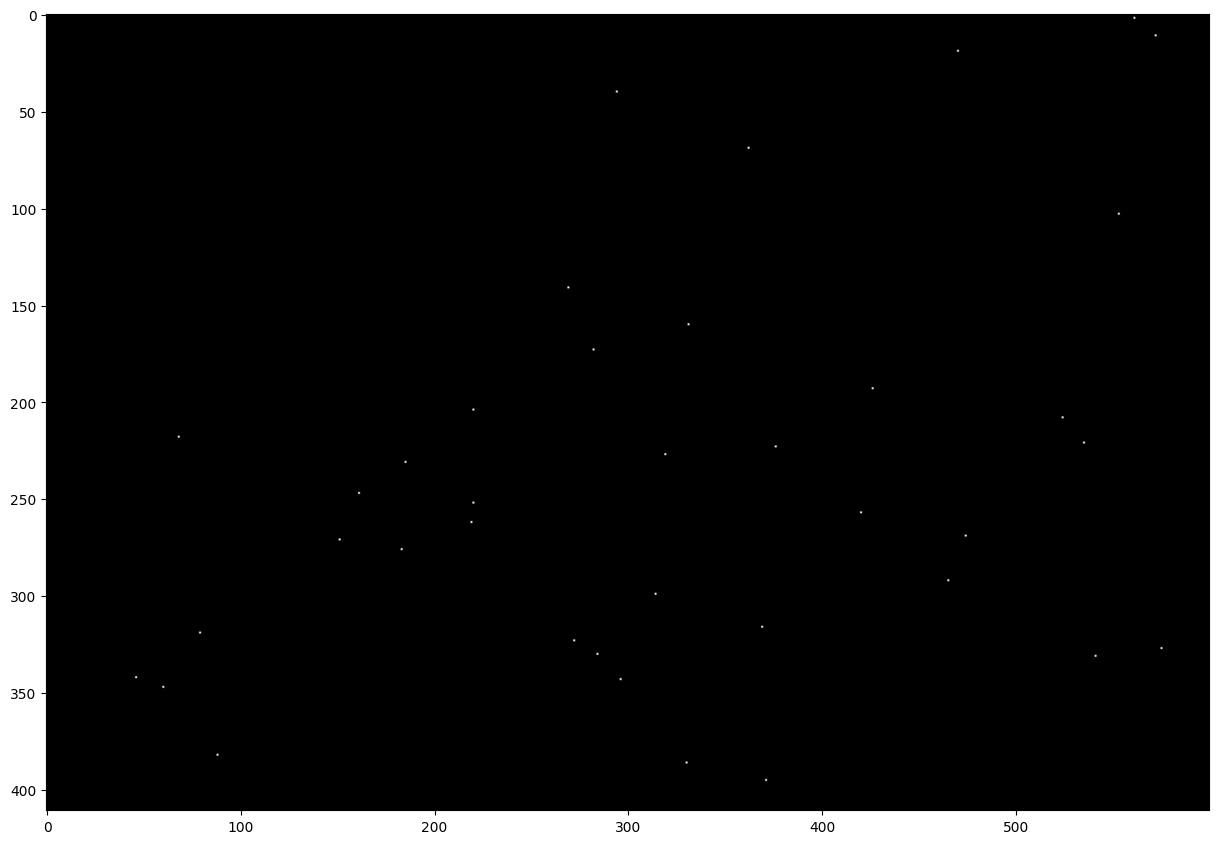

In [28]:
# Construct the structuring element
s13 = np.array((
        [0, 0, 1],
        [1, 1, 0],
        [0, 1, 0]), dtype="int")

 
# Apply hit-or-miss transformation
img_s4_1 = ndimage.binary_hit_or_miss(thinned, structure1=s13).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s4_1, cmap = 'gray')

/tmp/ipykernel_75318/1697849404.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s4_2 = ndimage.binary_hit_or_miss(thinned, structure1=s14).astype(np.int)


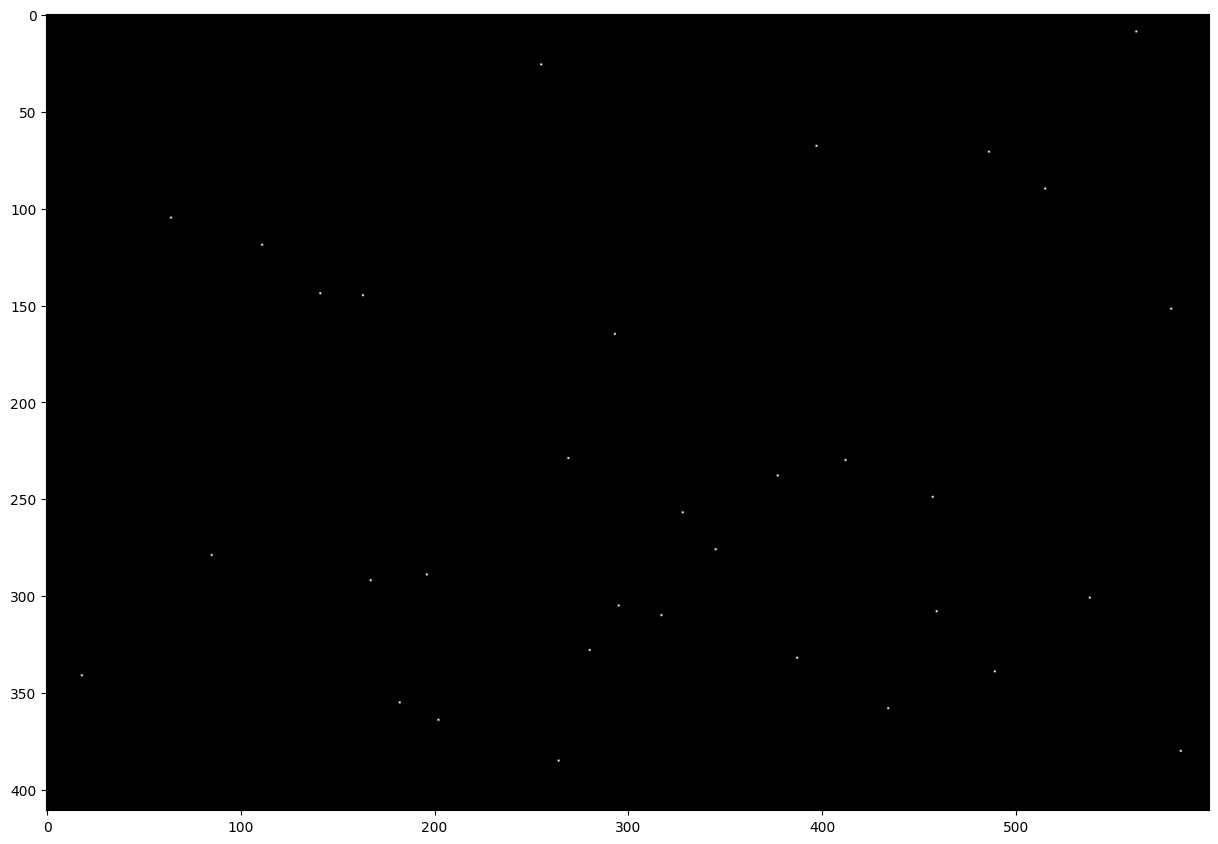

In [29]:
# Construct the structuring element
s14 = np.array((
        [0, 1, 0],
        [1, 1, 0],
        [0, 0, 1]), dtype="int")

 
# Apply hit-or-miss transformation
img_s4_2 = ndimage.binary_hit_or_miss(thinned, structure1=s14).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s4_2, cmap = 'gray')

/tmp/ipykernel_75318/4085588586.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s4_3 = ndimage.binary_hit_or_miss(thinned, structure1=s15).astype(np.int)


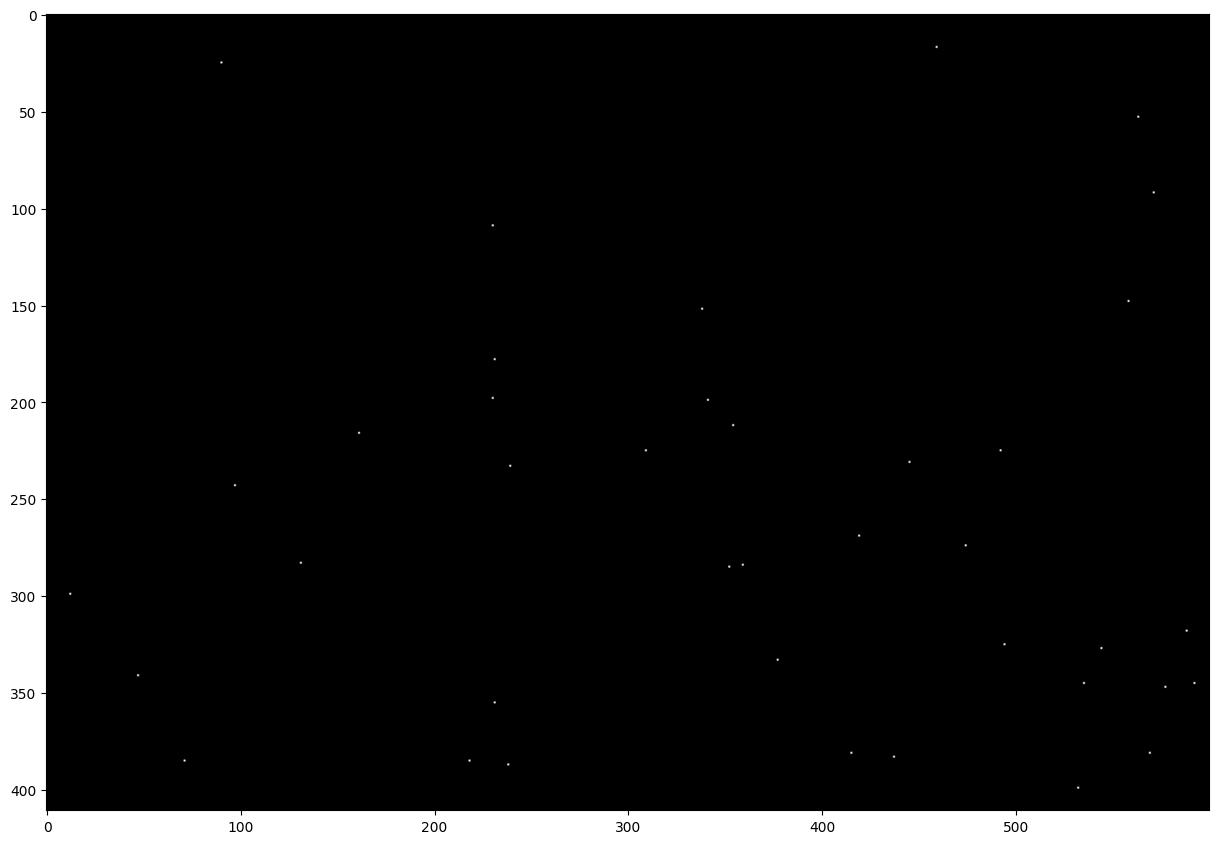

In [30]:
# Construct the structuring element
s15 = np.array((
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0]), dtype="int")

 
# Apply hit-or-miss transformation
img_s4_3 = ndimage.binary_hit_or_miss(thinned, structure1=s15).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s4_3, cmap = 'gray')

/tmp/ipykernel_75318/671448944.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_s4_4 = ndimage.binary_hit_or_miss(thinned, structure1=s16).astype(np.int)


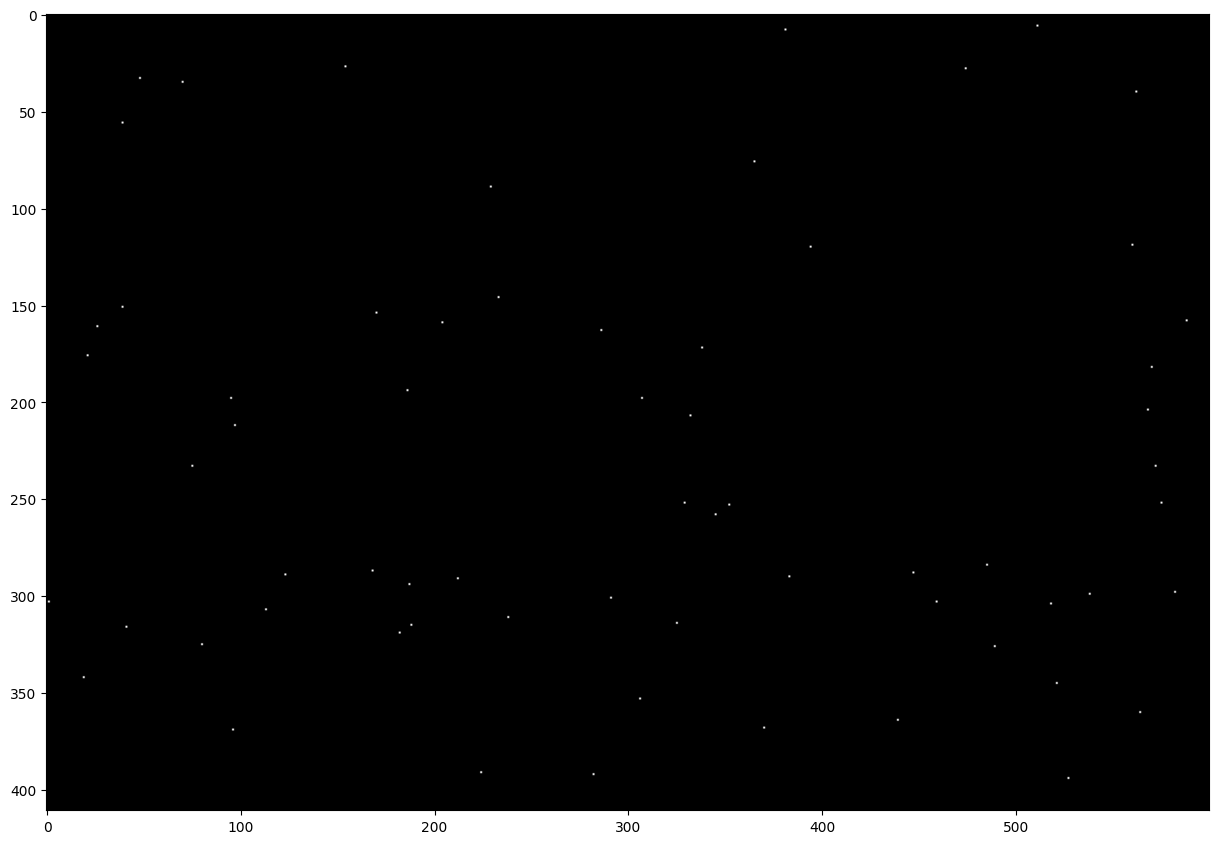

In [31]:
# Construct the structuring element
s16 = np.array((
        [1, 0, 0],
        [0, 1, 1],
        [0, 1, 0]), dtype="int")

 
# Apply hit-or-miss transformation
img_s4_4 = ndimage.binary_hit_or_miss(thinned, structure1=s16).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(img_s4_4, cmap = 'gray')

Below I have added output image of all the four structuring element and their different orintations. The image contain all the triple points including false triple points that comes due to the dangling branches. 



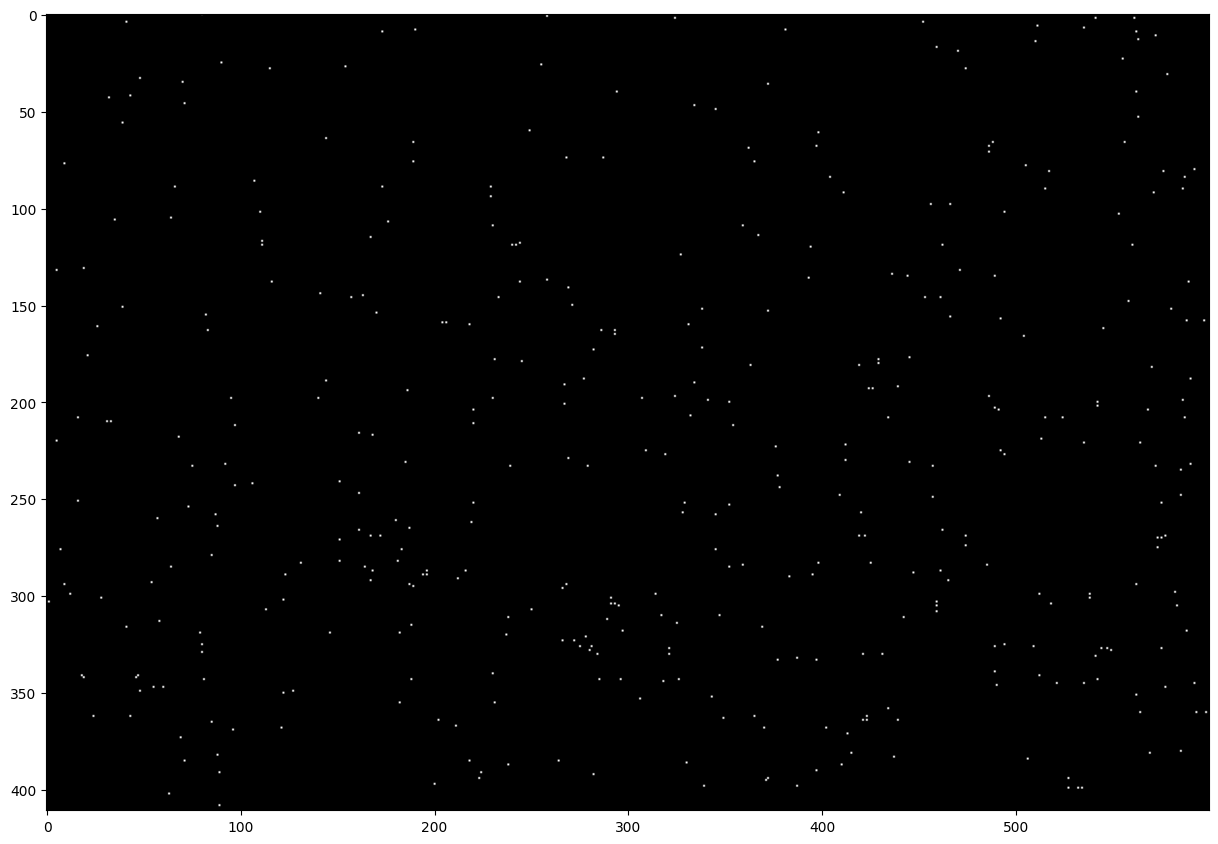

In [32]:
#addition of all the 16 different image
img_final = img_s1_1 + img_s1_2 + img_s1_3 + img_s1_4 + img_s2_1 + img_s2_2 + img_s2_3 + img_s2_4 + img_s3_1 + img_s3_2 + img_s3_3 + img_s3_4 + img_s4_1 + img_s4_2 + img_s4_3 + img_s4_4
plt.figure(figsize=(15,15))
plt.imshow(img_final, cmap = 'gray')


Below code determines the total numbers of triple point and it's co-ordinates. \\
*Note*: The number of triple point we are getting is much larger as it contain false triple junctions also (means dangling branch as a triple point). 

In [33]:
#determining the total number of triple point junction
pixels=[]
count=0
for i in range(img_final.shape[0]):
  for j in range(img_final.shape[1]):
    if img_final[i][j]==True:
      pixels.append((i,j))
      count=count+1

print("total number of triple junctions = ",count)


total number of triple junctions =  410


In [35]:
#corodinate of triple junction
print("pixels that has triple junction, also contain false triple point- ",pixels)

pixels that has triple junction, also contain false triple point-  [(0, 80), (1, 258), (2, 324), (2, 541), (2, 561), (4, 41), (4, 452), (6, 511), (7, 535), (8, 190), (8, 381), (9, 173), (9, 562), (11, 572), (13, 563), (14, 510), (17, 459), (19, 470), (23, 555), (25, 90), (26, 255), (27, 154), (28, 115), (28, 474), (31, 578), (33, 48), (35, 70), (36, 372), (40, 294), (40, 562), (42, 43), (43, 32), (46, 71), (47, 334), (49, 345), (53, 563), (56, 39), (60, 249), (61, 398), (64, 144), (66, 189), (66, 488), (66, 556), (68, 397), (68, 486), (69, 362), (71, 486), (74, 268), (74, 287), (76, 189), (76, 365), (77, 9), (78, 505), (80, 592), (81, 517), (81, 576), (84, 404), (84, 587), (86, 107), (89, 66), (89, 173), (89, 229), (90, 515), (90, 586), (92, 411), (92, 571), (94, 229), (98, 456), (98, 466), (102, 110), (102, 494), (103, 553), (105, 64), (106, 35), (107, 176), (109, 230), (109, 359), (114, 367), (115, 167), (117, 111), (118, 244), (119, 111), (119, 240), (119, 242), (119, 462), (119, 56

###Determining the co-ordinate of grain boundary

To determine the co-ordinate of grain boundaries, I scan 8 neighbouring pixels of each triple point. If any of the neighbouring pixel is found as a true (fourground pixel) then I reccorded the co-ordinate, similerly I scanned the complete image.  

To remove the dangling branch and false triple points, I take a threshold of 5 consecutive pixels. Means, if the number of consecutive neighbouring pixel is less then 5 then it will be considerd as a dangling branch and this coordinate will not be considerd as a grain boundary pixel. 



 Say (x,y) is a coordinate of triple point then the matrix which used to scan the neighbouring pixel will look like;

 $\begin{pmatrix}
  x-1, y+1  & x, y+1& x+1,y + 1\\ 
  x-1, y & x,y& x+1,y\\
  x-1, y-1   & x, y-1 & x+1,y - 1
\end{pmatrix}$



In [36]:

def getpos(x,y):
  points=[]
  if thinned[x-1][y]==True:
    points.append([x-1,y])
  if thinned[x+1][y]==True:
    points.append([x+1,y])
  if thinned[x][y-1]==True:
    points.append([x,y-1])
  if thinned[x][y+1]==True:
    points.append([x,y+1])
  if thinned[x-1][y-1]==True:
    points.append([x-1,y-1])
  if thinned[x-1][y+1]==True:
    points.append([x-1,y+1])
  if thinned[x+1][y-1]==True:
    points.append([x+1,y-1])
  if thinned[x+1][y+1]==True:
    points.append([x+1,y+1])
  if len(points)>3:
    points=points[:3]
  return points
  

  

In [38]:
def getposmid(k,temp):
  x,y=k
  if x-1>=0: 
    if thinned[x-1][y]==True and [x-1,y]!=temp:
      if (x-1,y) not in pixels:
        return([x-1,y])
  if x+1<w:
    if thinned[x+1][y]==True and [x+1,y]!=temp:
      if (x+1,y) not in pixels:
        return([x+1,y])
  if y-1>=0:
    if thinned[x][y-1]==True and [x,y-1]!=temp:
      if (x,y-1) not in pixels:
        return([x,y-1])
  if y+1<h:
    if thinned[x][y+1]==True and [x,y+1]!=temp:
      if (x,y+1) not in pixels:
        return([x,y+1])
  if x-1>=0 and y-1>=0:
    if thinned[x-1][y-1]==True and [x-1,y-1]!=temp:
      if (x-1,y-1) not in pixels:
        return([x-1,y-1])
  if x-1>=0 and y+1<h:
    if thinned[x-1][y+1]==True and [x-1,y+1]!=temp:
      if (x-1,y+1) not in pixels:
        return([x-1,y+1])
  if x+1<w and y-1>=0:
    if thinned[x+1][y-1]==True and [x+1,y-1]!=temp:
      if (x+1,y-1) not in pixels:
        return([x+1,y-1])
  if x+1<w and y+1<h:
    if thinned[x+1][y+1]==True and [x+1,y+1]!=temp:
      if (x+1,y+1) not in pixels:
        return([x+1,y+1])
  return -1

In [39]:
w,h=thinned.shape[0],thinned.shape[1]

In [40]:
finalpix=[]
connections=[]
for i in pixels:
  connect=[]
  l1=[]
  l2=[]
  l3=[]
  x,y=i
  pos=getpos(x,y)
  count=0
  for j in pos:
    count+=1
    flag=1
    k=j
    if count==1:
      while(flag==1):
        l1.append(k)
        if len(l1)==1:
          temp=l1[-1]
        else:
          temp=l1[-2]
        
        newtemp=getposmid(k,temp)
        if newtemp==-1:
          break
        if newtemp in pixels:
          flag=0
        x1,y1=newtemp
        if newtemp in pos:
          break
        if x1==0 or x1>=w or y1==0 or y1>=h:
          flag=0
        if flag==1:
          k=newtemp
        if len(l1)>=20:
          flag=0
    if count==2:
      while(flag==1):
        l2.append(k)
        if len(l2)==1:
          temp=l2[-1]
        else:
          temp=l2[-2]
        newtemp=getposmid(k,temp)
        if newtemp==-1:
          break
        if newtemp in pixels:
          flag=0
        if newtemp in pos:
          flag=0
        x1,y1=newtemp
        if x1==0 or x1>=w or y1==0 or y1>=h:
          flag=0
        if flag==1:
          k=newtemp
        if len(l2)>=20:
          flag=0
    if count==3:
      while(flag==1):
        l3.append(k)
        if len(l3)==1:
          temp=l3[-1]
        else:
          temp=l3[-2]
        newtemp=getposmid(k,temp)
        if newtemp==-1:
          break
        if newtemp in pixels:
          flag=0
        if newtemp in pos:
          flag=0
        x1,y1=newtemp
        if x1==0 or x1>=w or y1==0 or y1>=h:
          flag=0
        if flag==1:
          k=newtemp
        if len(l3)>=10:
          flag=0
  if len(l1)>5 and len(l2)>5 and len(l3)>5:
    connect.append(l1)
    connect.append(l2)
    connect.append(l3)
    connections.append(connect)
    finalpix.append(i)
    
        



In [41]:
len(finalpix)

190

We can see it clearly that the number of pixel is now reduced from 410 to 190. These 190 pixels belongs to the true triple point junction pixels.

In [42]:
#coordinate of true triple junction pixels
finalpix

[(6, 511),
 (8, 381),
 (11, 572),
 (19, 470),
 (23, 555),
 (25, 90),
 (27, 154),
 (31, 578),
 (33, 48),
 (35, 70),
 (40, 294),
 (40, 562),
 (42, 43),
 (43, 32),
 (49, 345),
 (53, 563),
 (56, 39),
 (61, 398),
 (68, 397),
 (69, 362),
 (76, 365),
 (77, 9),
 (78, 505),
 (81, 517),
 (84, 404),
 (86, 107),
 (89, 173),
 (89, 229),
 (90, 515),
 (92, 571),
 (98, 466),
 (103, 553),
 (114, 367),
 (115, 167),
 (119, 111),
 (120, 394),
 (124, 327),
 (132, 471),
 (134, 436),
 (135, 444),
 (135, 489),
 (136, 393),
 (137, 258),
 (138, 116),
 (138, 589),
 (141, 269),
 (144, 141),
 (145, 163),
 (146, 453),
 (152, 338),
 (152, 580),
 (155, 82),
 (158, 588),
 (160, 218),
 (160, 331),
 (161, 26),
 (162, 545),
 (163, 286),
 (166, 504),
 (172, 338),
 (173, 282),
 (178, 231),
 (181, 419),
 (182, 570),
 (188, 277),
 (188, 590),
 (189, 144),
 (191, 267),
 (197, 324),
 (198, 140),
 (198, 230),
 (198, 307),
 (199, 341),
 (199, 586),
 (200, 352),
 (201, 267),
 (204, 220),
 (204, 491),
 (204, 568),
 (207, 332),
 (2

Below are the coordinate of 20 neighbouring grain boundary pixels starting from each triple points. Now in order to get the angle between grain boundaries first I have to fit a polynomial into these coordinates taking triple point as an origin. 



In [43]:
#20 neighbour triple point coordinates from each triple points
print(connections)

[[[[7, 511], [8, 511], [9, 511], [10, 511], [11, 511], [12, 511], [13, 510]], [[6, 512], [6, 513], [5, 514], [5, 515], [4, 516], [4, 517], [4, 518], [3, 519], [3, 520], [3, 521], [3, 522], [2, 523], [3, 524], [3, 525], [3, 526], [3, 527], [4, 528], [4, 529], [5, 530], [6, 531]], [[5, 510], [4, 509], [3, 508], [2, 507], [2, 506], [1, 505], [1, 504]]], [[[9, 381], [10, 381], [11, 381], [12, 381], [13, 381], [14, 380], [15, 380], [16, 379], [17, 379], [18, 379], [19, 378], [20, 378], [21, 378], [22, 377], [23, 377], [24, 376], [25, 376], [26, 376], [27, 375], [28, 375]], [[8, 382], [8, 383], [7, 384], [7, 385], [6, 386], [6, 387], [6, 388], [5, 389], [5, 390], [4, 391], [4, 392], [4, 393], [3, 394], [3, 395], [3, 396], [3, 397], [3, 398], [3, 399], [3, 400], [3, 401]], [[7, 380], [6, 379], [5, 378], [5, 377], [4, 376], [3, 375], [3, 374], [2, 373], [1, 372], [1, 371]]], [[[12, 572], [13, 572], [14, 573], [15, 573], [16, 574], [17, 574], [18, 574], [19, 574], [19, 573], [18, 573], [18, 572

Below I have written a code to show how this image will look with 20 negighbourhood pixels of grain boundary from each triple point. And for comparision I have again shown a thinned image ( singele pixel image of grain boundary). 

In [44]:
imgnew=np.zeros((w,h))
truevalues=[]
for i in finalpix:
  x,y=i
  truevalues.append((x,y))
for i in connections:
  for j in range(3):
    k=i[j]
    for p in k:
      x,y=p[0],p[1]
      truevalues.append((x,y))



In [45]:
for i in truevalues:
  x,y=i
  imgnew[x][y]=1

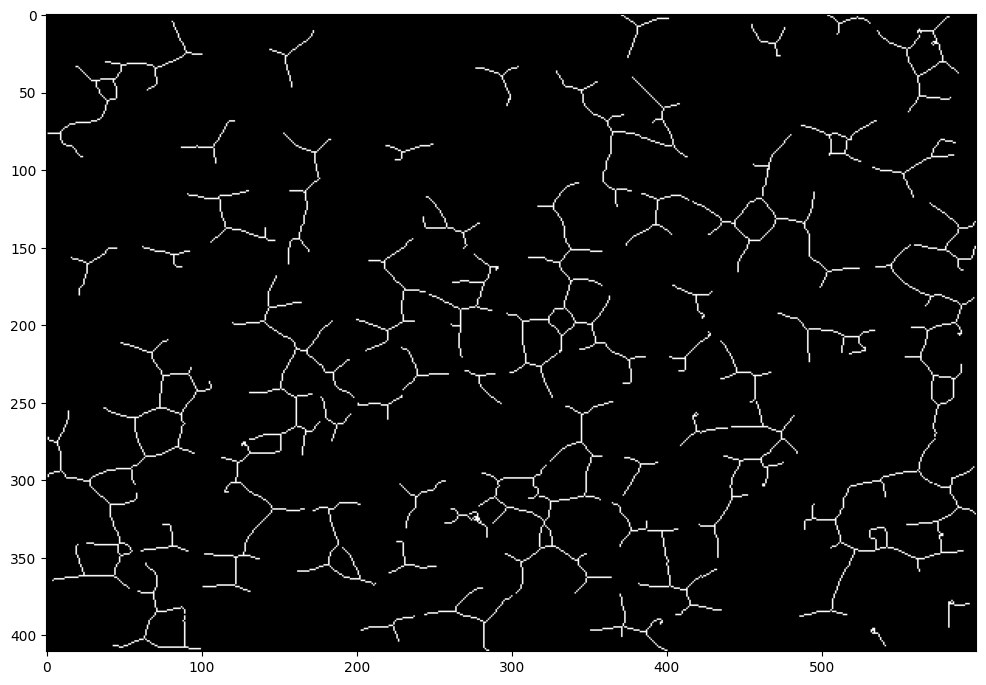

In [46]:
plt.figure(figsize=(12,12))
plt.imshow(imgnew,cmap='gray')

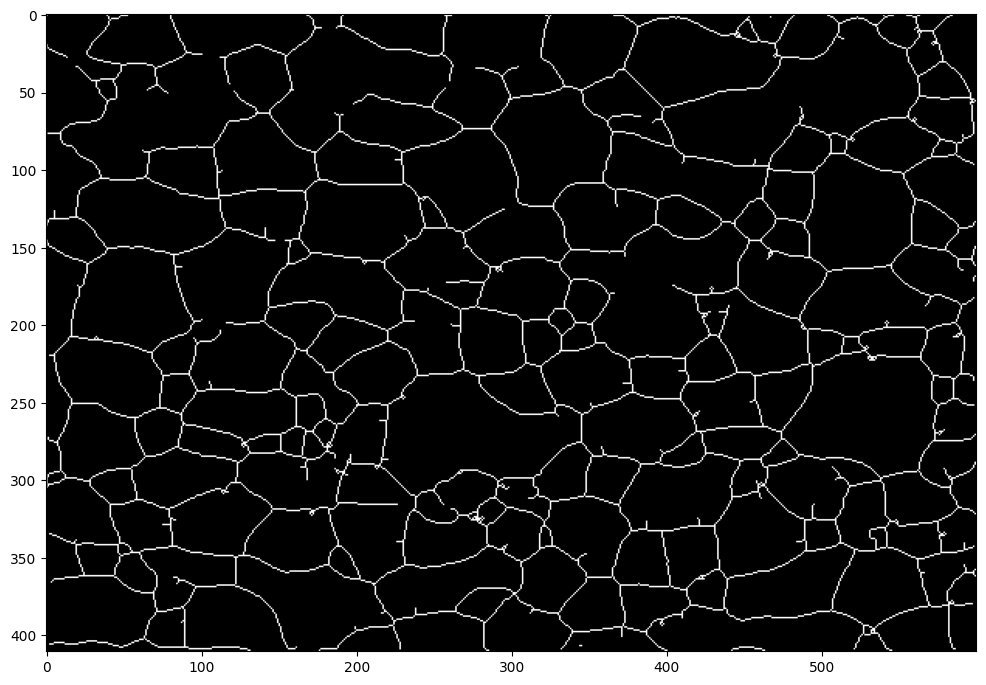

In [47]:
plt.figure(figsize=(12,12))
plt.imshow(thinned,cmap='gray')

Now I fitted a $3^{rd}$ order polynomial starting from each triple point and determine the coefficients using below code. Once I get the coefficients, in the next step I determine the deravitives of fitted polynomial that use for finding the tangent angle between the grain boundary. 

I use the below formula to determine the tangent angle between grain boundary;


\begin{equation}
    \tan \theta =\dfrac{f_{2}^{\prime}\left( x_{0}\right) -f_{1}^{\prime}\left( x_{0}\right) }{1+f_{2}^{\prime}\left( x_{0}\right) f_{1}^{\prime}\left( x_{0}\right)  }
\end{equation}






In [48]:
#3rd order polynomial 
def diff(fit,x,y):
  l=3*fit[0]*x*x + 2*fit[1]*x + fit[2]
  return l

In [49]:

def getangles(fit1,fit2,x,y):
  l1=diff(fit2,x,y)
  l2=diff(fit1,x,y)
  #print((l1-l2)/(1+l1*l2))
  angle=(np.arctan((l1-l2)/(1+l1*l2)))*180/np.pi
  if angle<0:
    angle=180+angle
  return angle



In [50]:
finalangles=[]
for i in range(len(finalpix)):
  angles=[]
  pixel=finalpix[i]
  x,y=pixel
  fit1=polynomialparams[i][0]
  fit2=polynomialparams[i][1]
  fit3=polynomialparams[i][2]
  angle1=getangles(fit1,fit2,x,y)
  angle2=getangles(fit2,fit3,x,y)
  angle3=getangles(fit3,fit1,x,y)
  if angle1+angle2+angle3!=360:
    angle3=360-angle1-angle2
  angles.append(angle1)
  angles.append(angle2)
  angles.append(angle3)
  finalangles.append(angles)




NameError: name 'polynomialparams' is not defined

In [47]:
polynomialparams

NameError: name 'polynomialparams' is not defined

In [ ]:
#printing angles between grain boundary in for each triple point
finalangles

[[123.8318495953559, 120.17192886846126, 115.99622153618282],
 [102.88037673588289, 112.36133012150755, 144.75829314260955],
 [155.48400714291762, 134.716858757709, 69.79913409937339],
 [71.69904809838022, 54.134887214538814, 234.16606468708096],
 [80.79755517695556, 47.95929838075179, 231.24314644229267],
 [59.06872084214833, 75.38776665410873, 225.54351250374296],
 [142.52195258031452, 74.51179416028175, 142.96625325940371],
 [134.77300309920906, 103.57514777660633, 121.6518491241846],
 [24.55344540026415, 71.44220100862672, 264.0043535911091],
 [141.5508677989437, 88.07785672730643, 130.3712754737499],
 [48.3936697448835, 93.80627680858252, 217.80005344653398],
 [69.57299385651919, 99.47526203798814, 190.95174410549265],
 [71.23978173574778, 21.86450122532874, 266.89571703892346],
 [68.69533961299172, 34.64579036527583, 256.65887002173247],
 [55.48675559594488, 39.289187902525484, 265.2240565015296],
 [112.36402041861086, 82.57084100813641, 165.06513857325274],
 [161.7273562245097, 

Below I have written a code to show the angle between any random pixels with curve fittng on it.

In [48]:
pixel=finalpix[30]
connect=connections[30]
angles=finalangles[30]
colors=['Red','black','yellow']
for i in range(3):
    points=connect[i]
    x=[]
    y=[]
    a,b=pixel
    x.append(a)
    y.append(b)
    for j in range(len(points)):
      x.append(points[j][0])
      y.append(points[j][1])
    
    x=np.asarray(x)
    y=np.asarray(y)
    fit = np.polyfit(x,y,3)
    params.append(fit)
    y_dash=fitpol(fit,x)
    plt.plot(x,y_dash,color=colors[i])
    plt.scatter(x,y,color=colors[i])

#print(angles)
print("angle b/w red and black = ",angles[0])
print("angle b/w yellow and black = ",angles[1])
print("angle b/w red and yellow = ",angles[2])

IndexError: list index out of range

##Conclusion 

The measurment of dihedral angle has been taken in each triple point. These angles provide unique
signatures of the accuracy of grain growth energetic anisotropy of grain boundaries,
and microstructural dimensionality. I have used an image processing technique to determine the true triple point junction and the coordinates of neighbouring grain boundary. The angle between grain boundary is determined via the derivitives of $3^{rd}$ order polynomial. 
